In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import *
import matplotlib
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.cluster import MeanShift , estimate_bandwidth
%matplotlib inline

C:\Users\omar\miniconda3\envs\tensorenv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install yellowbrick

In [2]:
sales = pd.read_csv("D:/Machine_Learning_Data/online_retail_II.csv")

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [3]:
# convert the InvoiceDate to the right format
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])

In [6]:
sales.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [4]:
sales.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
negprice = sales[sales['Price']<0]
negquantit = sales[sales['Quantity']<0]

In [6]:
## take out the negative prices from the sales data
sales = sales[sales['Price']>=0]

In [7]:
## we have also identify some descriptions that doesnt look like sales
sales2 = sales[sales['Description'].isin(['?',
'?????',
'back charges',
'bad quality',
'Came as green?',
'Came as green?',
'cant find',
'cant find',
'check',
'checked',
'checked',
'code mix up 72597',
'code mix up 72597',
'coding mix up',
'crushed',
'crushed',
'damaged',
'damaged/dirty',
'damaged?',
'damages',
'damages etc',
'damages, lost bits etc',
'damages?',
'damges',
'Damp and rusty',
'dirty',
'dirty, torn, thrown away.',
'display',
'entry error',
'faulty',
'for show',
'given away',
'gone',
'Gone',
'incorrect credit',
'lost',
'lost in space',
'lost?',
'missing',
'Missing',
'missing (wrongly coded?)',
'missing?',
'missings',
'reverse mistake',
'Rusty ',
'Rusty connections',
'show',
'show display',
'smashed',
'sold in wrong qnty',
'This is a test product.',
'used for show display',
'wet',
'wet & rotting',
'wet and rotting',
'wet cartons',
'wet ctn',
'wet damages',
'Wet, rusty-thrown away',
'wet/smashed/unsellable',
'wrong code',
'wrong ctn size',
'Zebra invcing error'])]

In [8]:
sales.shape, sales2.shape

((1067366, 8), (551, 8))

In [9]:
## so lets take those spurious sales out
sales = sales[~sales.apply(tuple,1).isin(sales2.apply(tuple,1))]

In [10]:
sales.shape

(1067350, 8)

In [11]:
sales.isnull().sum().values

array([     0,      0,   4382,      0,      0,      0, 243002,      0],
      dtype=int64)

In [12]:
sales.isnull().sum().values[2]/sales.shape[0]*100

0.4105494917318593

In [13]:
sales.isnull().sum().values[6]/sales.shape[0]*100

22.766852485126716

 About 20% of the dataset has missing customer ID and 0.4% of the dataset has no description
 SO I willa ssume that the missing customer id are 9999 and the description is 'Unlnown'

In [14]:
sales[['Customer ID']] = sales[['Customer ID']].fillna(9999)

In [15]:
sales[['Description']] = sales[['Description']].fillna('Unkown')

In [16]:
## Now Lets find the first and second time a customer ordered by aggregating the values
sales_ = sales.groupby('Invoice').agg(
    Customer =('Customer ID', 'first'),
    InvoiceDate2=('InvoiceDate', 'min'))

In [66]:
### A little explanation of aggregation
df = pd.DataFrame([
                   [1, 2, 7],
                   [4, 5, 6],
                   [7, 8, 9],
                   [1, 2, 3]],
                  columns=['A', 'B', 'C'])

df.groupby('A').agg(
    customer = ('B', 'first'),
    Date = ('C', 'min'))

In [17]:
sales_[:10]

,Customer,InvoiceDate2
Invoice,,
489434,13085.0,2009-12-01 07:45:00
489435,13085.0,2009-12-01 07:46:00
489436,13078.0,2009-12-01 09:06:00
489437,15362.0,2009-12-01 09:08:00
489438,18102.0,2009-12-01 09:24:00
489439,12682.0,2009-12-01 09:28:00
489440,18087.0,2009-12-01 09:43:00
489441,18087.0,2009-12-01 09:44:00
489442,13635.0,2009-12-01 09:46:00


In [18]:
sales_.reset_index(inplace = True)

In [19]:
sales_[:10]

,Invoice,Customer,InvoiceDate2
0,489434,13085.0,2009-12-01 07:45:00
1,489435,13085.0,2009-12-01 07:46:00
2,489436,13078.0,2009-12-01 09:06:00
3,489437,15362.0,2009-12-01 09:08:00
4,489438,18102.0,2009-12-01 09:24:00
5,489439,12682.0,2009-12-01 09:28:00
6,489440,18087.0,2009-12-01 09:43:00
7,489441,18087.0,2009-12-01 09:44:00
8,489442,13635.0,2009-12-01 09:46:00
9,489443,14110.0,2009-12-01 09:50:00


In [20]:
sales_['daterank'] = sales_.groupby('Customer')['InvoiceDate2'].rank(method = 'first',ascending = True)

In [21]:
sales_[:21]

,Invoice,Customer,InvoiceDate2,daterank
0,489434,13085.0,2009-12-01 07:45:00,1.0
1,489435,13085.0,2009-12-01 07:46:00,2.0
2,489436,13078.0,2009-12-01 09:06:00,1.0
3,489437,15362.0,2009-12-01 09:08:00,1.0
4,489438,18102.0,2009-12-01 09:24:00,1.0
5,489439,12682.0,2009-12-01 09:28:00,1.0
6,489440,18087.0,2009-12-01 09:43:00,1.0
7,489441,18087.0,2009-12-01 09:44:00,2.0
8,489442,13635.0,2009-12-01 09:46:00,1.0
9,489443,14110.0,2009-12-01 09:50:00,1.0


In [22]:
sales_ = sales_[sales_['daterank']==2]

In [23]:
sales_.shape

(4482, 4)

In [24]:
sales_.head()

,Invoice,Customer,InvoiceDate2,daterank
1,489435,13085.0,2009-12-01 07:46:00,2.0
7,489441,18087.0,2009-12-01 09:44:00,2.0
15,489450,16321.0,2009-12-01 10:36:00,2.0
18,489462,17592.0,2009-12-01 10:49:00,2.0
20,489464,9999.0,2009-12-01 10:52:00,2.0


In [25]:
sales_.drop(['Invoice', 'daterank'], axis = 1, inplace = True)

In [26]:
sales_.columns = ['Customer ID', 'InvoiceDate2']

In [27]:
sales['amount'] = sales['Price']*sales['Quantity']

In [28]:
salesgroup = sales.groupby('Customer ID').agg(
    Country=('Country', 'first'),
    sum_price=('Price', 'sum'),
    sum_quantity=('Quantity', 'sum'),
    max_date=('InvoiceDate', 'max'),
    min_date=('InvoiceDate', 'min'),
    count_order=('Invoice', 'nunique'),
    avgprice=('Price', 'mean'),
    sum_amount =('amount', 'sum'),
    count_product=('Invoice', 'count'))

In [29]:
salesgroup.reset_index(inplace=True)

In [30]:
salesgroup.head(2)

,Customer ID,Country,sum_price,sum_quantity,max_date,min_date,count_order,avgprice,sum_amount,count_product
0,9999.0,United Kingdom,2.090277e+06,374359,2011-12-09 10:26:00,2009-12-01 10:52:00,8747,8.601890,2.797634e+06,243002
1,12346.0,United Kingdom,5.389400e+02,7,2011-01-18 10:17:00,2010-01-26 17:27:00,7,14.182632,-2.636800e+02,38


In [31]:
#Find the max date of this study
maxdate = sales['InvoiceDate'].max()
print(maxdate)

2011-12-09 12:50:00


- monetary = sum_amount
- avgitemprice = avgprice

In [32]:
#Calculate AOV. Item per basket
salesgroup['avgordervalue'] = salesgroup['sum_amount']/salesgroup['count_order']
salesgroup['itemsperbasket'] = salesgroup['sum_quantity']/salesgroup['count_order']

In [33]:
# join the data with the dataframe containing customer id with 2nd visits
salesgroup = pd.merge(salesgroup, sales_ , how='left', on=['Customer ID'])

In [34]:
salesgroup.head()

,Customer ID,Country,sum_price,sum_quantity,max_date,min_date,count_order,avgprice,sum_amount,count_product,avgordervalue,itemsperbasket,InvoiceDate2
0,9999.0,United Kingdom,2.090277e+06,374359,2011-12-09 10:26:00,2009-12-01 10:52:00,8747,8.601890,2.797634e+06,243002,319.839296,42.79856,2009-12-01 10:52:00
1,12346.0,United Kingdom,5.389400e+02,7,2011-01-18 10:17:00,2010-01-26 17:27:00,7,14.182632,-2.636800e+02,38,-37.668571,1.00000,2010-03-02 13:08:00
2,12347.0,Iceland,6.441600e+02,3286,2011-12-07 15:52:00,2010-10-31 14:20:00,8,2.546087,5.633320e+03,253,704.165000,410.75000,2010-12-07 14:57:00
3,12348.0,Finland,1.931000e+02,2714,2011-09-25 13:13:00,2010-09-27 14:59:00,5,3.786275,2.019400e+03,51,403.880000,542.80000,2010-12-16 19:09:00
4,12349.0,Italy,1.504590e+03,1619,2011-11-21 09:51:00,2009-12-04 12:49:00,5,8.358833,4.404540e+03,180,880.908000,323.80000,2010-04-29 13:20:00


In [35]:
salesgroup.columns

Index(['Customer ID', 'Country', 'sum_price', 'sum_quantity', 'max_date',
       'min_date', 'count_order', 'avgprice', 'sum_amount', 'count_product',
       'avgordervalue', 'itemsperbasket', 'InvoiceDate2'],
      dtype='object')

In [36]:
# find difference between first purchase and 2nd purchase 
salesgroup['daysreturn'] = salesgroup['InvoiceDate2']-salesgroup['min_date']

In [37]:
salesgroup[['daysreturn']][:5]

,daysreturn
0,0 days 00:00:00
1,34 days 19:41:00
2,37 days 00:37:00
3,80 days 04:10:00
4,146 days 00:31:00


In [38]:
salesgroup['daysreturn'] = salesgroup['daysreturn']/np.timedelta64(1,'D')

In [39]:
salesgroup[['daysreturn']][:5]

,daysreturn
0,0.000000
1,34.820139
2,37.025694
3,80.173611
4,146.021528


In [40]:
salesgroup['daysmaxmin']  = salesgroup['max_date']- salesgroup['min_date']
salesgroup['daysmaxmin'] = (salesgroup['daysmaxmin']/np.timedelta64(1,'D'))+1

In [41]:
salesgroup['daysmaxmin'][:5]

0    738.981944
1    357.701389
2    403.063889
3    363.926389
4    717.876389
Name: daysmaxmin, dtype: float64

In [42]:
salesgroup['frequency'] = np.where(salesgroup['count_order'] >1,salesgroup['count_order']/salesgroup['daysmaxmin'],0)

In [43]:
salesgroup['recency']  = maxdate- salesgroup['max_date']
salesgroup['recency'] = salesgroup['recency']/np.timedelta64(1,'D')

In [44]:
salesgroup[['frequency','recency', 'sum_amount']].quantile([ .2, .4,0.6, .8])

,frequency,recency,sum_amount
0.2,0.000000,17.983333,259.35
0.4,0.011050,57.890972,585.27
0.6,0.020133,189.810417,1186.09
0.8,0.039934,413.108333,2862.40


In [45]:
quantiles2 = salesgroup[['frequency','recency', 'sum_amount']].quantile([ .2, .4,0.6, .8]).to_dict()
quantiles2

{'frequency': {0.2: 0.0,
  0.4: 0.011050253714592666,
  0.6: 0.02013333675102939,
  0.8: 0.03993354055689927},
 'recency': {0.2: 17.983333333333334,
  0.4: 57.890972222222224,
  0.6: 189.81041666666667,
  0.8: 413.10833333333335},
 'sum_amount': {0.2: 259.34999999999997,
  0.4: 585.2699999999999,
  0.6: 1186.0899999999995,
  0.8: 2862.4}}

In [46]:

def r_score2(y):
    if y <= quantiles2['recency'][0.2]:
        return 5
    elif y <= quantiles2['recency'][0.4]:
        return 4
    elif y <= quantiles2['recency'][0.6]:
        return 3
    elif y <= quantiles2['recency'][0.8]:
        return 2
    else : 
        return 1

In [47]:
def fm_score(y, k):
    if y <= quantiles2[k][0.2]:
        return 1
    elif y <= quantiles2[k][0.4]:
        return 2 
    elif y <= quantiles2[k][0.6]:
        return 3
    elif y <= quantiles2[k][0.8]:
        return 4
    else : 
        return 5

In [48]:
#lets get the RFM values by calling the function above

salesgroup['R2'] = salesgroup['recency'].apply(lambda y: r_score2(y))
salesgroup['F2'] = salesgroup['frequency'].apply(lambda y : fm_score(y, 'frequency'))
salesgroup['M2'] = salesgroup['sum_amount'].apply(lambda y : fm_score(y, 'sum_amount'))

In [49]:
salesgroup.columns[-3:]

Index(['R2', 'F2', 'M2'], dtype='object')

In [50]:
salesgroup['RFM2'] = salesgroup['R2'].map(str) + salesgroup['F2'].map(str) + salesgroup['M2'].map(str)

In [51]:
salesgroup['RFM2'] = salesgroup['RFM2'].astype(int)

In [52]:
def mapl(salesgroup, r_rule, fm_rule, label, colname='new_label'):
    salesgroup.loc[(salesgroup['R2'].between(r_rule[0], r_rule[1]))
            & (salesgroup['F2'].between(fm_rule[0], fm_rule[1])), colname] = label
    return salesgroup

In [53]:
salesgroup = mapl(salesgroup, (4,5), (4,5), 'Champions')
salesgroup = mapl(salesgroup, (2,5), (3,5), 'Loyal customers')
salesgroup = mapl(salesgroup, (3,5), (1,3), 'Potential loyalist')
salesgroup = mapl(salesgroup, (4,5), (0,1), 'New customers')
salesgroup = mapl(salesgroup, (3,4), (0,1), 'Promising')
salesgroup = mapl(salesgroup, (2,3), (2,3), 'Needing attention')
salesgroup = mapl(salesgroup, (2,3), (0,2), 'About to sleep')
salesgroup = mapl(salesgroup, (0,2), (2,5), 'At risk')
salesgroup = mapl(salesgroup, (0,1), (4,5), 'Cant loose them')
salesgroup = mapl(salesgroup, (1,2), (1,2), 'Hibernating')
salesgroup = mapl(salesgroup, (0,2), (0,2), 'Lost')

In [54]:
salesgroup[["new_label"]][:10]

,new_label
0,Loyal customers
1,At risk
2,Potential loyalist
3,Needing attention
4,Potential loyalist
5,Lost
6,Lost
7,Loyal customers
8,Lost
9,Lost


In [55]:
sales_cleaned = salesgroup[['Customer ID', 'Country', 'sum_price', 'sum_quantity', 'sum_amount',
        'frequency', 'recency','R2', 'F2', 'M2','RFM2', 'new_label']]

In [56]:
sales_cleaned.columns

Index(['Customer ID', 'Country', 'sum_price', 'sum_quantity', 'sum_amount',
       'frequency', 'recency', 'R2', 'F2', 'M2', 'RFM2', 'new_label'],
      dtype='object')

Text(0.5, 0, 'Customer Attributes')

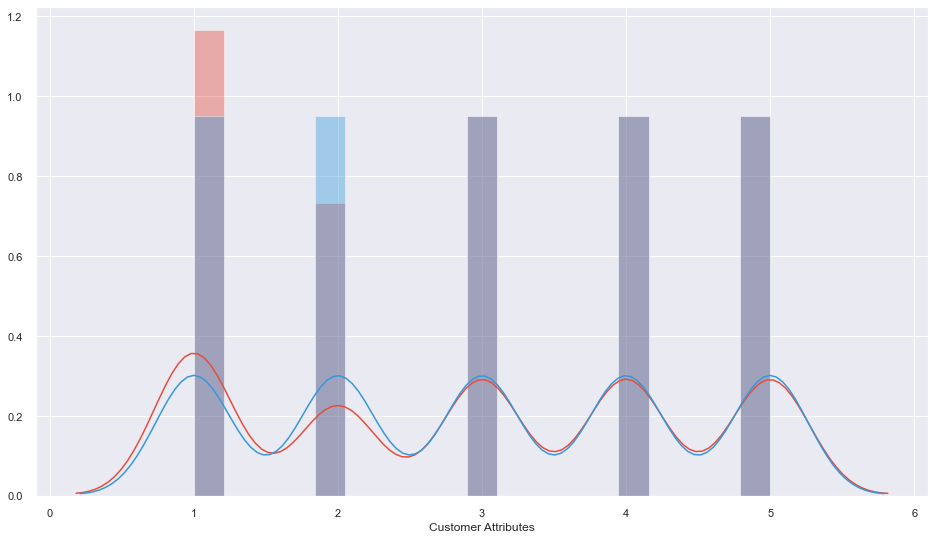

In [60]:
# Plot styling
#plt.rcParams['figure.figsize'] = (16, 9)
plt.figure(figsize=(16,9))
#mpl.style.use('ggplot') # for ggplot-like style
# let us Visualize the existing data
plot_frequency=sns.distplot(sales_cleaned['F2'], color="#e74c3c")
plot_monetary=sns.distplot(sales_cleaned['M2'], color="#3498db")
plt.xlabel('Customer Attributes')

In [57]:
sales_cl = sales_cleaned[['sum_amount', 'frequency', 'recency']]
sales_cl2 = sales_cleaned[[ 'sum_amount','frequency']] #2 column attributes

In [59]:
### Standar Scaling 
std_scaler = StandardScaler()

# fit sales1
std_scaler.fit(sales_cl)
sales_scaled = std_scaler.transform(sales_cl)

# fit the sales2
std_scaler.fit(sales_cl2)
sales_scaled2 = std_scaler.transform(sales_cl2)

In [60]:
sales_scaled.shape, sales_scaled2.shape

((5941, 3), (5941, 2))

#### K-means

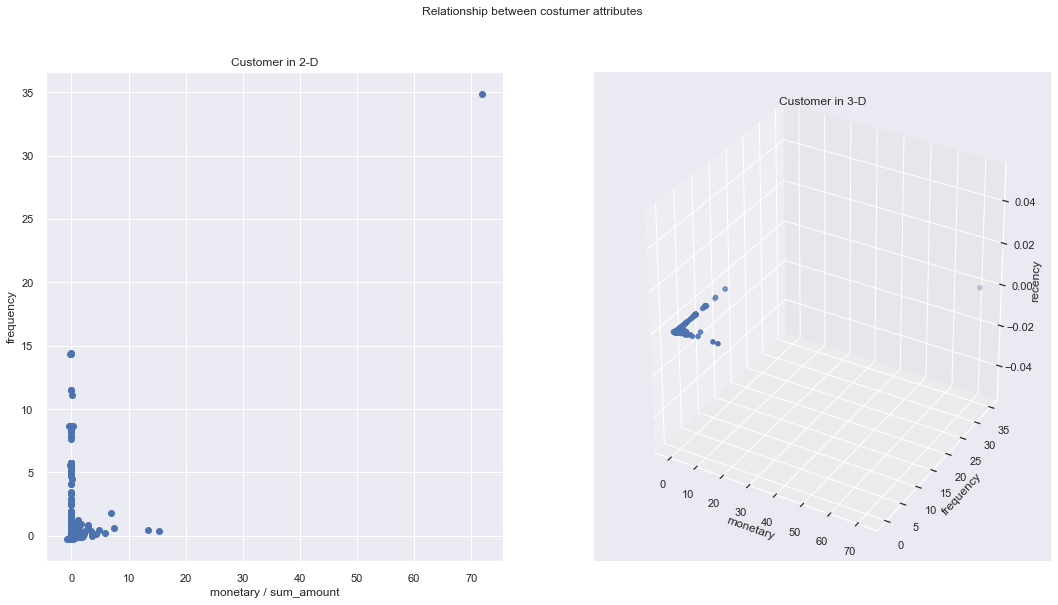

In [64]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (18,9))
fig.suptitle('Relationship between costumer attributes')

## First Subplot
d2 = fig.add_subplot(1,2,1)
d2.scatter(sales_scaled2[:,0], sales_scaled2[:,1])
d2.set_xlabel('monetary / sum_amount')
d2.set_ylabel('frequency')
d2.set_title('Customer in 2-D')

# Second Subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1]) #, sales_scaled[:, 2]) #, sales_scaled[:, 2])
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Customer in 3-D')

plt.show()

In [68]:
## Initializing K-means with 9 clusters

kmeans = KMeans(n_clusters=9)

## Training of the Model
Kmeans3D = kmeans.fit(sales_scaled) 
labels3D = Kmeans3D.predict(sales_scaled)
C3D = Kmeans3D.cluster_centers_
#####################################################

Kmeans2D = kmeans.fit(sales_scaled2)
labels2D = Kmeans2D.predict(sales_scaled2)
C2D = Kmeans2D.cluster_centers_

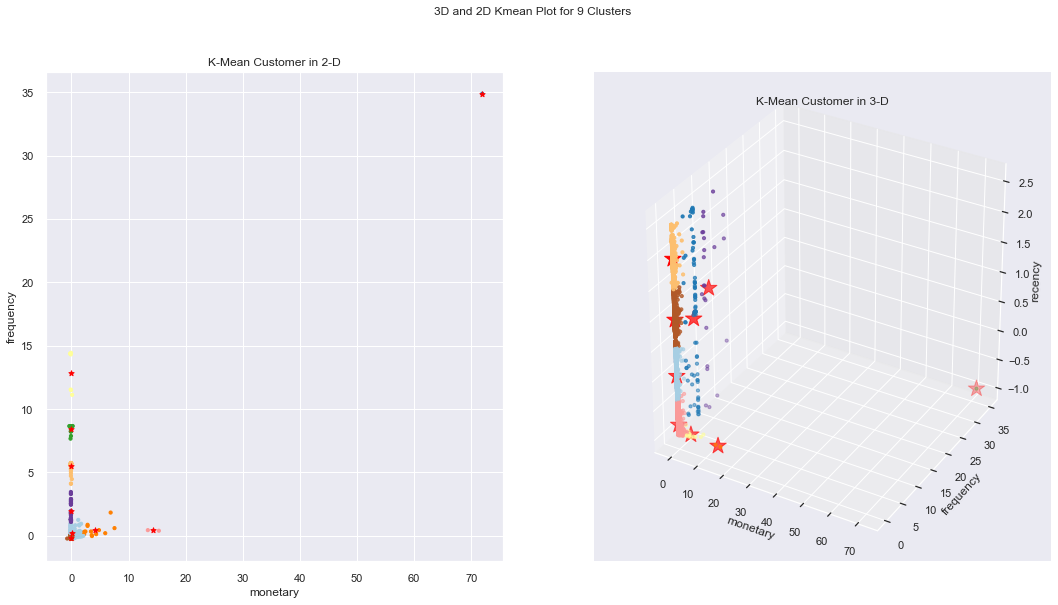

In [71]:
### Visualise the 6 clusters

fig = plt.figure(figsize=(18,9))
fig.suptitle('3D and 2D Kmean Plot for 9 Clusters')

## First plot
d2 = fig.add_subplot(1,2,1)
d2.scatter(sales_scaled2[:,0], sales_scaled2[:,1], c=labels2D, s=10, cmap='Paired')
d2.scatter(C2D[:,0],C2D[:,1], marker = '*', c='red', s=30)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('K-Mean Customer in 2-D')


### Second plot 
d3 = fig.add_subplot(1,2,2, projection = '3d')
d3.scatter(sales_scaled[:,0], sales_scaled[:,1],sales_scaled[:,2], c=labels3D,s=10, cmap = 'Paired')
d3.scatter(C3D[:,0],C3D[:,1],C3D[:,2],  marker = '*', c='red', s=300)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('K-Mean Customer in 3-D')

plt.show()

<Figure size 864x576 with 0 Axes>

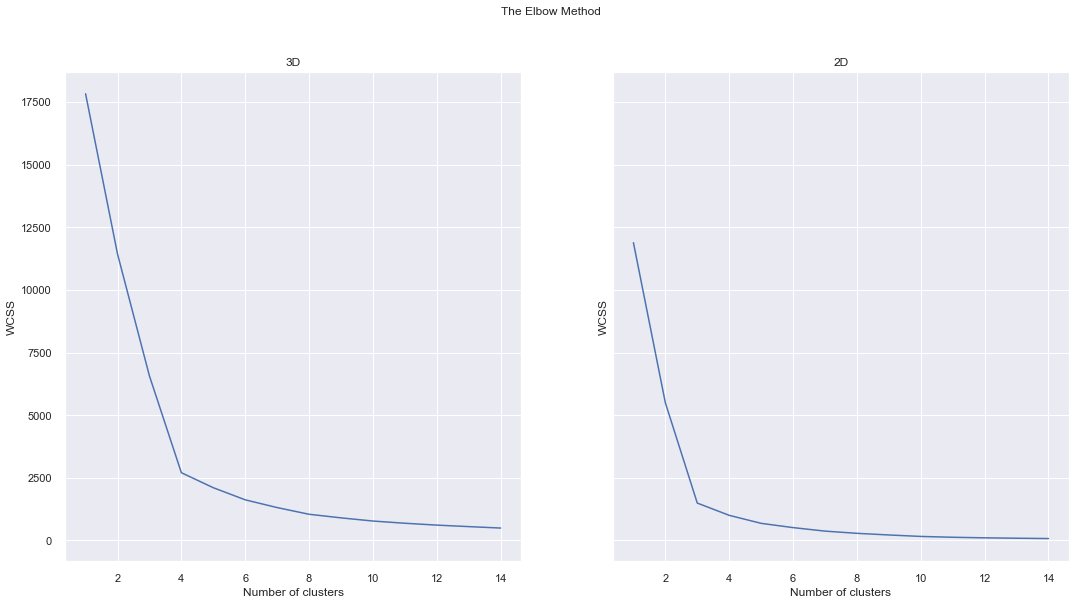

In [74]:
## Parameter Tuning for K-means to find Optimum Clusters

fig = plt.figure(figsize=(12,8))

wcss = []

for i in range(1,15):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(sales_scaled)
    wcss.append(kmeans.inertia_)

wcss2 = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state = 42)
    kmeans.fit(sales_scaled2)
    wcss2.append(kmeans.inertia_)

    
fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
fig.suptitle('The Elbow Method')
axs[0].plot(range(1, 15), wcss)
axs[0].set_title('3D')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')

axs[1].plot(range(1, 15), wcss2)
axs[1].set_title('2D')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('WCSS')

plt.show()


In [75]:
### Training the Model with 4 clusters

kmeans3D = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans3 = kmeans3D.fit_predict(sales_scaled)
labels_3D = y_kmeans3+1
cluster_3D = pd.DataFrame(labels_3D)
C3D = kmeans3D.cluster_centers_


#### working on 2D
kmeans2D = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans2 = kmeans2D.fit_predict(sales_scaled2)
labels_2D = y_kmeans2+1
cluster_2D = pd.DataFrame(labels_2D)
C2D = kmeans2D.cluster_centers_

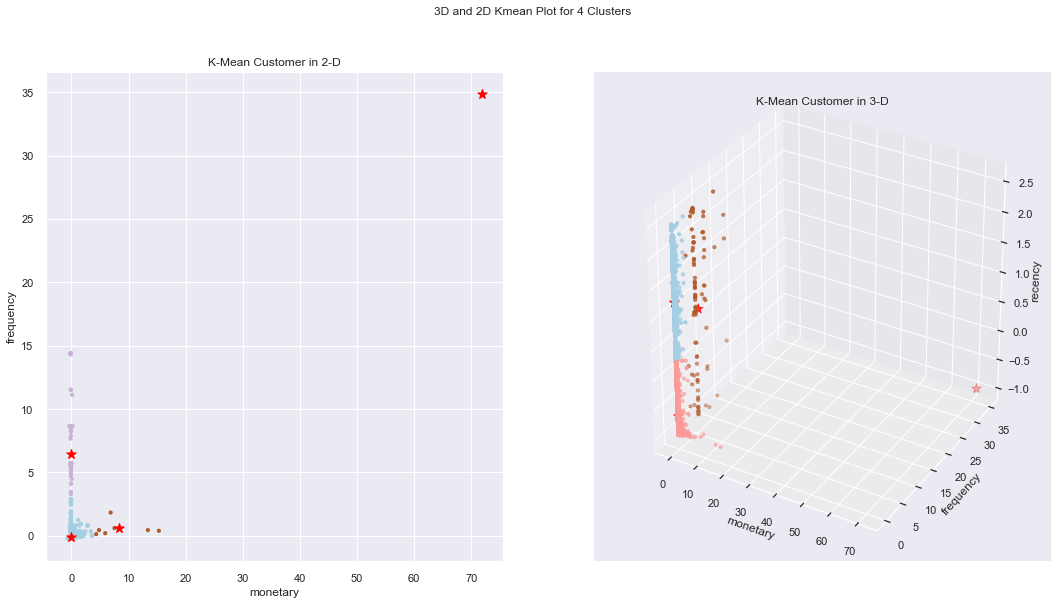

In [76]:
## Ploting the results

fig = plt.figure(figsize=(18,9))
fig.suptitle('3D and 2D Kmean Plot for 4 Clusters')


# First subplot
d2 = fig.add_subplot(1,2,1)
d2.scatter(sales_scaled2[:,0], sales_scaled2[:,1], c=labels_2D, s=10, cmap='Paired')
d2.scatter(C2D[:,0], C2D[:,1], marker = '*', c = 'red', s=100)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('K-Mean Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels_3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=100)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('K-Mean Customer in 3-D')

plt.show()

### Mean shift clustering algorithm

In [81]:
bandwith = estimate_bandwidth(sales_scaled,quantile=0.2 ,n_samples=5870)

msc = MeanShift(bandwidth=bandwith, bin_seeding=True)
msc.fit(sales_scaled)
labels_3D = msc.labels_
C3D = msc.cluster_centers_
unique_labels = np.unique(labels_3D)
n_clusters_ = len(unique_labels)
print("number of estimated meanshift clusters 3D : %d" % n_clusters_)


#################################

bandwith = estimate_bandwidth(sales_scaled2, quantile=0.2, n_samples=5870)

msc = MeanShift(bandwidth=bandwith, bin_seeding = True)
msc.fit(sales_scaled2)
labels_2D = msc.labels_
C2D = msc.cluster_centers_
unique_labels = np.unique(labels_2D)
n_clusters_ = len(unique_labels)

print("number of estimated meanshift clusters 2D : %d" % n_clusters_)


number of estimated meanshift clusters 3D : 33
number of estimated meanshift clusters 2D : 40


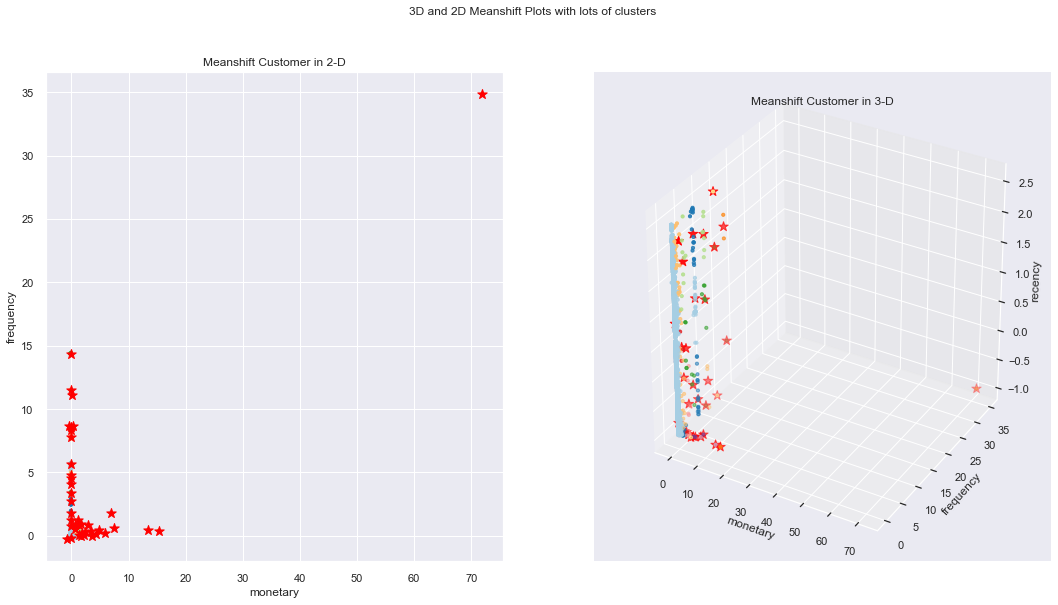

In [82]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Meanshift Plots with lots of clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels_2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=100)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Meanshift Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels_3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=100)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Meanshift Customer in 3-D')

plt.show()

33 clusters is too many clusters and impossible to interprete so lets restrict the number of cluster

In [85]:
bandwith = estimate_bandwidth(sales_scaled, quantile=0.9, n_samples=5870)
msc = MeanShift(bandwidth=bandwith, bin_seeding=True)
msc.fit(sales_scaled)
labels_3D = msc.labels_
C3D = msc.cluster_centers_
unique_labels = np.unique(labels_3D)
n_clusters_ = len(unique_labels)
print("number of estimated clusters 3D : %d" % n_clusters_)
#############    
bandwith = estimate_bandwidth(sales_scaled2, quantile=0.9, n_samples=5870)
msc = MeanShift(bandwidth=bandwith, bin_seeding=True)
msc.fit(sales_scaled2)
labels_2D = msc.labels_
C2D = msc.cluster_centers_
unique_labels = np.unique(labels_2D)
n_clusters_ = len(unique_labels)
print("number of estimated clusters 2D : %d" % n_clusters_)

number of estimated clusters 3D : 6
number of estimated clusters 2D : 23


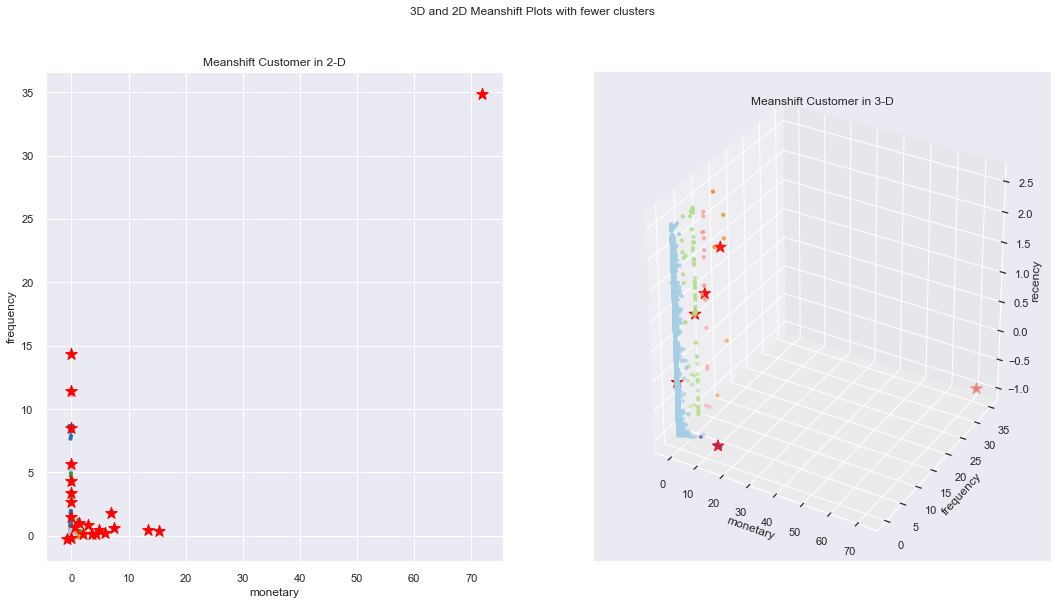

In [86]:
fig = plt.figure(figsize = (18,9))
fig.suptitle('3D and 2D Meanshift Plots with fewer clusters')

## First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels_2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=150)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Meanshift Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels_3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=150)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Meanshift Customer in 3-D')

plt.show()

### Gaussian Mixture Models

In [87]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=9).fit(sales_scaled)
labels_3D = gmm.predict(sales_scaled)
##############
gmm = GaussianMixture(n_components=9).fit(sales_scaled2)
labels_2D = gmm.predict(sales_scaled2)

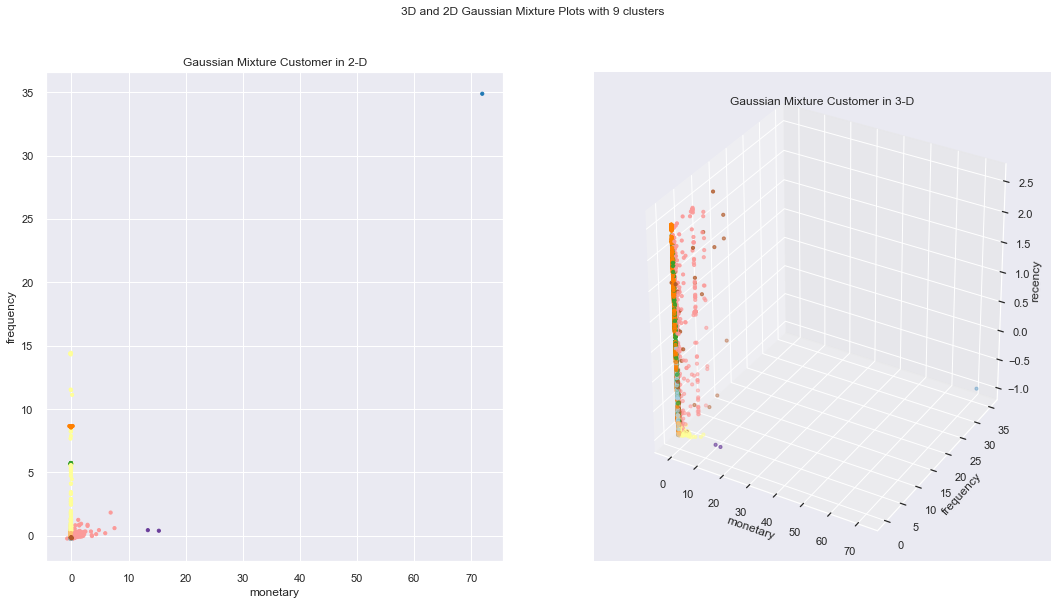

In [88]:
fig = plt.figure(figsize = (18,9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with 9 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels_2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Gaussian Mixture Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels_3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Gaussian Mixture Customer in 3-D')

plt.show()

In [90]:
n_components = np.arange(1,50)

models_3D = [GaussianMixture(n, covariance_type='full', random_state=0).fit(sales_scaled) for n in n_components]
models_2D = [GaussianMixture(n, covariance_type='full', random_state=0).fit(sales_scaled2) for n in n_components]

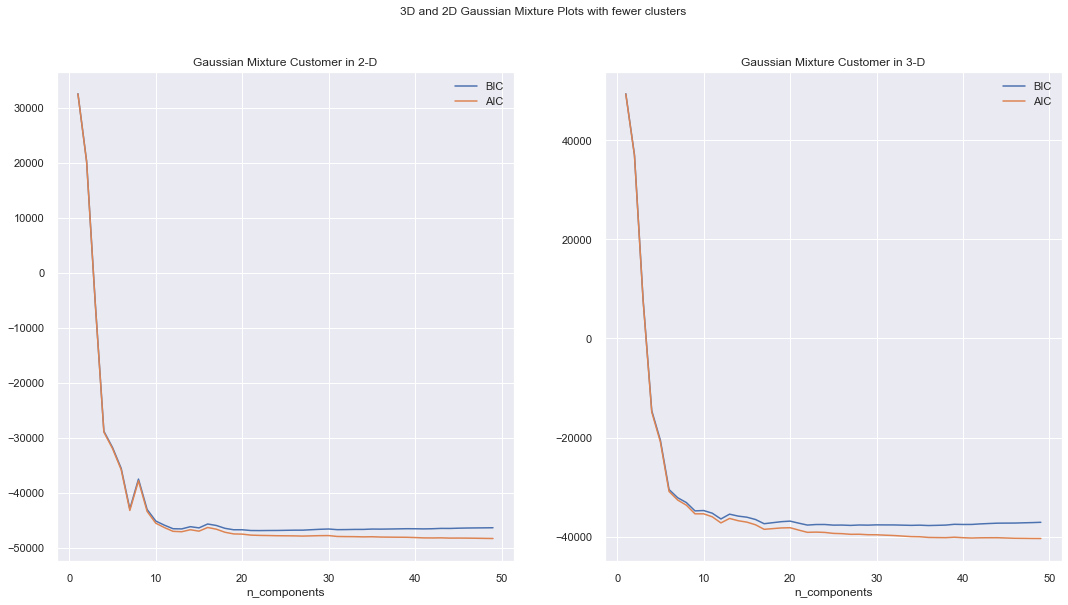

In [91]:
fig = plt.figure(figsize = (18,9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with fewer clusters')


d2 = fig.add_subplot(1,2,1)
d2.plot(n_components, [m.bic(sales_scaled2) for m in models_2D], label = 'BIC')
d2.plot(n_components, [m.aic(sales_scaled2) for m in models_2D], label = 'AIC')
d2.legend(loc = 'best')
d2.set_xlabel('n_components')
d2.set_title('Gaussian Mixture Customer in 2-D');


d3 = fig.add_subplot(1,2,2)
d3.plot(n_components, [m.bic(sales_scaled) for m in models_3D], label = 'BIC')
d3.plot(n_components, [m.aic(sales_scaled) for m in models_3D], label = 'AIC')
d3.legend(loc = 'best')
d3.set_xlabel('n_components')
d3.set_title('Gaussian Mixture Customer in 3-D');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. Both the AIC and BIC shows that the optimum value is between 40- 50 components which is way too much and difficult to interpret as seen in the Meanshift clustering model so I will probably take the previous deep in the line graph which is between 10 and 20 components.

In [92]:
# lets plot the 40 component GMM
gmm = GaussianMixture(n_components=40).fit(sales_scaled)
labels3D = gmm.predict(sales_scaled)
########################################################################################

# lets plot the 40 component GMM
gmm = GaussianMixture(n_components=40).fit(sales_scaled2)
labels2D = gmm.predict(sales_scaled2)

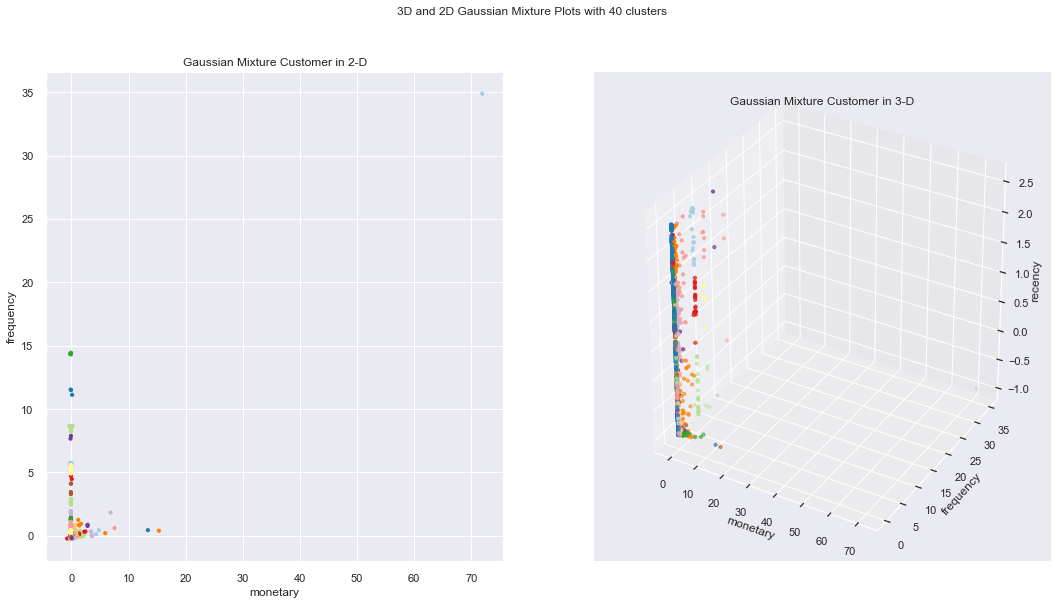

In [93]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with 40 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Gaussian Mixture Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Gaussian Mixture Customer in 3-D')

plt.show()

#### DBSCAN Clustering

In [94]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps = 0.4, min_samples=3).fit(sales_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True 
labels_3D = db.labels_

# number of clusters 

n_clusters_ = len(set(labels_3D)) - (1 if -1 in labels_3D else 0)
n_noise_ = list(labels_3D).count(-1)

print('3D Estimated number of clusters: %d' % n_clusters_)
print('3D Estimated number of noise points: %d' % n_noise_)
print("3D Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sales_scaled, labels_3D))
#########################
print('#########################')
db = DBSCAN(eps = 0.4, min_samples=3).fit(sales_scaled2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True 
labels_2D = db.labels_

n_clusters_ = len(set(labels_2D)) - (1 if -1 in labels_2D else 0)
n_noise_ = list(labels_2D).count(-1)

print('2D Estimated number of clusters: %d' % n_clusters_)
print('2D Estimated number of noise points: %d' % n_noise_)
print("2D Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sales_scaled2, labels_2D))


3D Estimated number of clusters: 9
3D Estimated number of noise points: 46
3D Silhouette Coefficient: 0.485
#########################
2D Estimated number of clusters: 7
2D Estimated number of noise points: 15
2D Silhouette Coefficient: 0.894


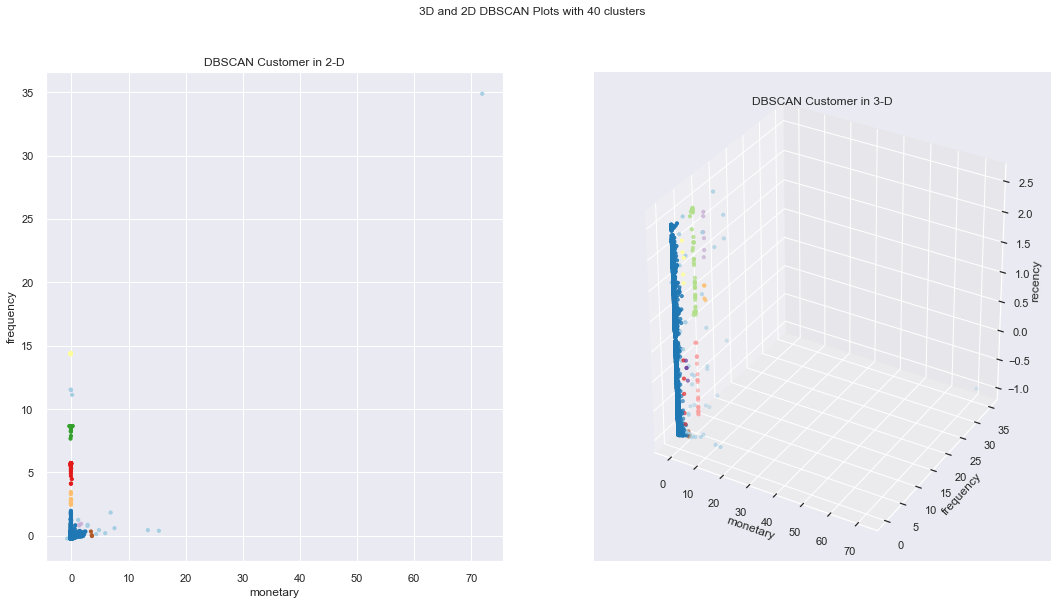

In [95]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D DBSCAN Plots with 40 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels_2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('DBSCAN Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels_3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')

d3.set_title('DBSCAN Customer in 3-D')

plt.show()